# Summary
- [Data](#Data)
- [Model](#Model)
- [Training](#Training)
    - [10-fold-cross-validation](#10-fold-cross-validation)
- [Visualization](#Visualization)
    - [Interpretation](#Interpretation)
- [Implemented-but-not-used](#Implemented-but-not-used)
    - [Debug](#Debug)

# Dependencies


In [1]:

#visualization
import matplotlib.pyplot as plt
#math tools
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import resample
from scipy.signal import decimate
#machine learning
import torch
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)
#utils
from time import time
import warnings
from os.path import join
from os.path import exists
from os import makedirs
from os import listdir
import pickle

#custom
from modules.utils import *
from modules.load_data import *
from modules.model import Model
from modules.encoder import Encoder
from modules.training import *
from modules.tcn import *

cuda


# Utils
Cf `utils.py`

In [2]:

def plot(plot_i,train,valid,test,average=True):
    if average:
        print(model_name.replace(",","|"))
        if early_stopping:
            title = "average {} over 10 folds over the {} first epochs".format(index2plot[plot_i],shortest_fold)
        else:
            title = "average {} over 10 folds over {} epochs".format(index2plot[plot_i],n_epochs)
    else :
        train,test=np.asarray(train),np.asarray(test)
        if valid is not None:
            valid=np.asarray(valid)
        title=model_name
    plt.figure()
    plt.title(title)
    plt.plot(train[:,plot_i],label="training")
    if valid is not None:
        plt.plot(valid[:,plot_i],label="validation")
    plt.plot(test[:,plot_i],label="test")
    plt.xlabel("epochs")
    plt.ylabel(index2plot[plot_i])
    plt.legend()

def return_results(train_metrics,valid_metrics,test_metrics,stopped_at,flat_falses):
    train_metrics,test_metrics=np.asarray(train_metrics),np.asarray(test_metrics)
    if early_stopping:
        valid_metrics=np.asarray(valid_metrics)
        str_valid_metrics="{:.2f} (± {:.2f})".format(np.mean(valid_metrics[:,1]),np.std(valid_metrics[:,1]))
    else:
        str_valid_metrics="NA"
    
    task_name=index2task[task_i] if task_i is not None else str(task_i)
    results="{} ; {} ; {} ; {}   ; {} ; {} ; {} ; {} ; {:.2f} (± {:.2f}) ; None ; {} ; {} ; TRUE ; {} ; FALSE ; {:.2f} (± {:.2f}) ; {} ".format(
    task_name,model_type,learning_rate, hidden_size,num_layers,bidirectional,dropout,clip,
    np.mean(stopped_at),np.std(stopped_at),compute_movement_,early_stopping,downsampling_factor,
     np.mean(train_metrics[:,1]),np.std(train_metrics[:,1]), str_valid_metrics)

    test_metrics=test_metrics.T
    for metric in test_metrics[1:]:#don't care about the loss
        mean,std=np.mean(metric),np.std(metric)
        results+="; {:.2f} (± {:.2f}) ".format(mean,std)
    results+=" ; "
    results+=" ; ".join(map(str, flat_falses))
    return results
def print_results():
    try:
        if early_stopping:
            folds_lengths=[len(fold) for fold in fold_valid_metrics]
            assert True#np.max(folds_lengths) < n_epochs
            print("number of epochs before early stopping for each fold:\n",folds_lengths)
            longest_fold=np.argmax(folds_lengths)
            shortest_fold=np.min(folds_lengths)
            average_stop=int(round(np.mean(folds_lengths)-patience))-1#-1 to index to it
            med_stop=int(round(np.median(folds_lengths)-patience-1))#-1 to index to it
            best_index=-1#-patience-1
            stopped_at=[len(fold)-patience-5 for fold in fold_valid_metrics]
        else:
            shortest_fold=None#fake value so we can return it
            best_index=np.argmax(np.mean(fold_test_metrics,axis=0)[:,1])      
            stopped_at=[best_index+1]
    except AssertionError:
        print("The model didn't early stop therefore fold[-patience-1] is not the best epoch")    
    else:    
        best_falses=[fold[best_index] for fold in fold_falses]
        flat_falses = sorted(flat_list(best_falses))
        results=return_results([fold[best_index] for fold in fold_train_metrics],
                     None, #[fold[best_index] for fold in fold_valid_metrics],
                      [fold[best_index] for fold in fold_test_metrics],
                      stopped_at,
                       flat_falses)
        print(results)
        return shortest_fold

# Data
Cf `load_data.py`
## Loading

## Task selection
set `task_i` to None if you want to train the model on all tasks at once (i.e. early fusion)  
Else set `task_i` to the desired task index (cf. task2index)

## Compute movement
Transforms data as Zhang et al. (cf Report #5)

## Scale then downsample (or not) then concatenate task id (or not)
Set `downsampling_factor` to `1` if you don't want to downsample
## Split in subsequence (or not)
Set `window_size` to `None` if you don't want to split data into subsequence of fixed length  
Set `paper_air_split` to `False` if you don't want to split data into strokes

In [3]:
## Loading
#Cf `load_data.py`
task_i=task2index["spiral"]
compute_speed_accel_=False
compute_movement_=False
downsampling_factor=1
window_size=None
paper_air_split=False
try:
    assert window_size is None or not paper_air_split
except AssertionError:
    print("you have to choose between subsequences of fixed length and strokes !")
try:
    assert not (task_i is None and (compute_movement_ or compute_speed_accel_))
except AssertionError:
    print("compute_movement_ and compute_speed_accel_ are only implemented for single task learning !")               
else:
    print("\nloading and massaging data, this might take a few seconds...")
    data_gen=load_data()
    data,targets=[],[]
    for subject,label,_ in data_gen:
        data.append(subject)
        targets.append(label)
    print("(75-3 subjects, 8 tasks, X timesteps, 7 measures)")
    print(len(data),len(data[0]),len(data[0][0]),len(data[0][0][0]))
    if compute_movement_ and compute_speed_accel_:
        warnings.warn("Only spped and accel will be computed ! \nSet compute_speed_accel_ to False if you want to compute movement")
    data, targets= massage_data(data, targets,task_i, compute_speed_accel_,compute_movement_, downsampling_factor, window_size,paper_air_split)


loading and massaging data, this might take a few seconds...
(75-3 subjects, 8 tasks, X timesteps, 7 measures)
72 8 1772 7

task index, name
0 spiral
len(data), len(data[0]) :
72 1772

neither speed nor movement was computed (i.e. data was not transformed)

scaling 
len(data), len(targets), len(data[0]) :
72 72 1772
the task is represented as one single sequence  (i.e. data was not transformed)


# Model
Cf. `model.py`  
Cf. Report on the code for details about the architecture of the model

- [**Pytorch LSTM doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [**Pytorch GRU doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU)
- [**Pytorch Linear doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)
- [**Pytorch Binary Cross Entropy loss (BCELoss) doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)

# Training
Cf. `training.py`  


## Hyperparameters
The hyperparameters are not always relevant for the chosen model_type.  
In this case they won't matter give them a random value.  
Choose model_type from models.  

In [7]:
models=["lstm","gru","tcn","cnn1d"]
model_type="tcn"
assert model_type in models
augmentation=False
learning_rate = 1e-4
hidden_size=2
num_layers=4
bidirectional=False
dropout=0.5
clip=None#clipping value to clip the gradients norm : set to None if you don't want to clip
kernel_size=10
dilation_factor=10
#if we perform single task learning on the whole sequence
if task_i is not None and window_size is None and not paper_air_split:
    input_size=len(data[0][0])#==7 if we take all the measures into account
else:
    input_size=len(data[0][0][0])#==7+8 if we train on multiple tasks, 7 if we train on subsequences (and single task)

bias=True
batch_first=False#we should unsqueeze(1) to add a batch dimension
batch_size=1
output_size=1#binary classif : 1 means PD, 0 means control

loss_fn=torch.nn.BCELoss()#Binary cross entropy

if model_type=="tcn":
    num_channels=[hidden_size for _ in range(num_layers)]
model_name=model_type+str((task_i,learning_rate,hidden_size,num_layers, bidirectional, dropout,
                           clip,window_size,kernel_size,dilation_factor))
print("input_size :",input_size)
print(model_name)

input_size : 7
tcn(0, 0.0001, 2, 4, False, 0.5, None, None, 10, 10)


## 10 fold cross validation

- set `run_CV` to `False` if you just want to train on one fold.
- set `early_stopping` to `False` if you just want to train on a fixed n° of epochs.

In [8]:

run_CV=False#if False, breaks after one fold, else runs CV
early_stopping=False
n_epochs=100#max n° of epochs the model will be trained to
#n° of epochs without improvement during which the model will wait before stopping (if early_stopping)
patience = 10#useless if not early_stopping
verbose=False
fold_train_metrics,fold_test_metrics,fold_falses=[],[],[]
start = time()
np.random.seed(1)
save_to_print=""

skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data,targets)

for fold,(train_index,test_index) in enumerate(cv_generator): 
     
    if fold in np.arange(0):
        print("SKIPPING FOLD")
        continue
    train_metrics,test_metrics,falses=[],[],[]

    torch.manual_seed(1)#random seed for weights init
    if model_type=="tcn":
        model= TemporalConvNet(input_size,num_channels,kernel_size,dropout,output_size=1,dilation_factor=dilation_factor)
    elif model_name=="lstm":
        model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                     dropout,bidirectional, batch_size,output_size, is_lstm=True)
        model.init_forget_bias()
    elif model_type=="gru":
        model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                     dropout,bidirectional, batch_size,output_size, is_lstm=False)
    elif model_type=="cnn1d":
        model=CNN1d(input_size,hidden_size,dropout)
    else:
        raise ValueError("got {} as model_type but expected one of {}".format(model_type,models))
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if fold==0:        
        print("(total n° of parameters, n° of trainable parameters) :")
        print(model.count_params())   
        print("architecture :")
        print(model)
    

    best_accuracy=0
    #best_loss=10000.0
    impatience=0
    for i in range(n_epochs):                
        to_print=""
        np.random.shuffle(train_index)#shuffle training to facilitate SGD        
        #training
        model.train()
        [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, train_index,device=device,
            clip=clip,validation=False,window_size=window_size,task_i=task_i,augmentation=augmentation,paper_air_split=paper_air_split)
        train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
        to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

        #test
        model.eval()
        [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, test_index,device=device,
            validation=True,window_size=window_size,task_i=task_i,augmentation=False,paper_air_split=paper_air_split)    
        test_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        falses.append(false)
        to_print+="\nTEST : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)       

        #patience update
        #useless if not early stopping
        if accuracy <= best_accuracy:#`<=` no improvement is considered bad !#loss>=best_loss:
            impatience+=1
        else:
            best_accuracy=accuracy #best_loss=loss#
            impatience=0
        if verbose:
            print(to_print)
        save_to_print+=to_print
        #early stopping
        if impatience >= patience and early_stopping:
            save_to_print+="\nEarly stopped."
            break     

    fold_train_metrics.append(train_metrics)
    fold_test_metrics.append(test_metrics)
    fold_falses.append(falses)
    if not run_CV:
        break
if not verbose:
    print(to_print)#save_to_print)

if run_CV:   
    # Save metrics
    filename=join("experiments",model_name)
    for metrics,metric_type in list(zip([fold_train_metrics,
    fold_test_metrics],["train","test"])):
        with open(filename+metric_type, 'wb') as fp:
            pickle.dump(metrics, fp)
    
    shortest_fold=print_results() 

(total n° of parameters, n° of trainable parameters) :
(471, 471)
architecture :
TemporalConvNet(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(7, 2, kernel_size=(10,), stride=(1,), padding=(9,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.5)
      (conv2): Conv1d(2, 2, kernel_size=(10,), stride=(1,), padding=(9,))
      (relu2): ReLU()
      (dropout2): Dropout(p=0.5)
      (downsample): Conv1d(7, 2, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(2, 2, kernel_size=(10,), stride=(1,), padding=(90,), dilation=(10,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.5)
      (conv2): Conv1d(2, 2, kernel_size=(10,), stride=(1,), padding=(90,), dilation=(10,))
      (relu2): ReLU()
      (dropout2): Dropout(p=0.5)
      (relu): ReLU()
    )
    (2): TemporalBlock(
      (conv1): Conv1d(2, 2, kernel_size=(10,), stride=(1,), padding=(900,), dilation=(100,))
      (relu1): ReLU()
      (dropout1): Drop

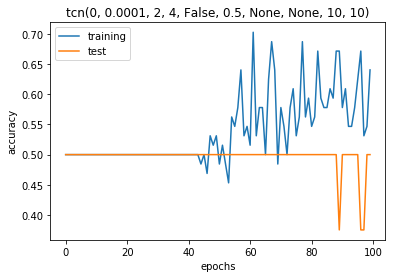

In [10]:
plot(1,train_metrics,None,test_metrics,False)

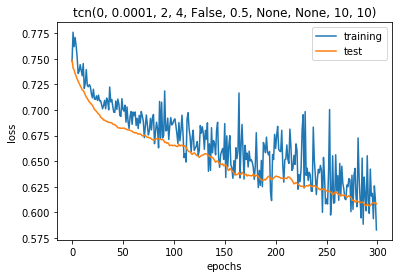

In [35]:
plot(0,train_metrics,None,test_metrics,False)

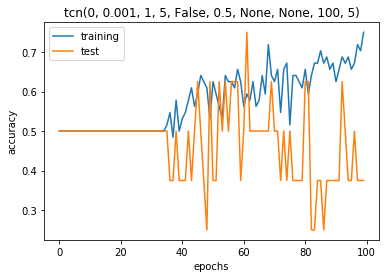

In [6]:
plot(1,train_metrics,None,test_metrics,False)

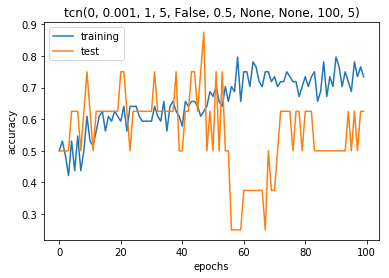

In [69]:
plot(1,train_metrics,None,test_metrics,False)

# with relu
## on fold 6

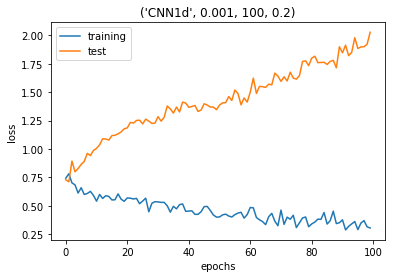

In [11]:
plot(0,train_metrics,None,test_metrics,False)

## on fold 1

In [76]:
model.training

False

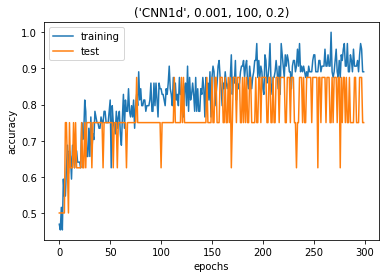

In [75]:
plot(1,train_metrics,None,test_metrics,False)

#  without relu

##  ON FOLD 6

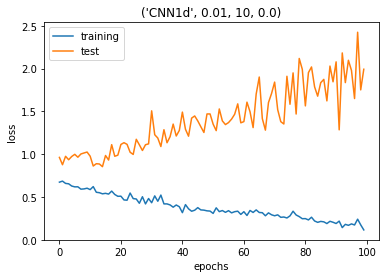

In [109]:
plot(0,train_metrics,None,test_metrics,False)

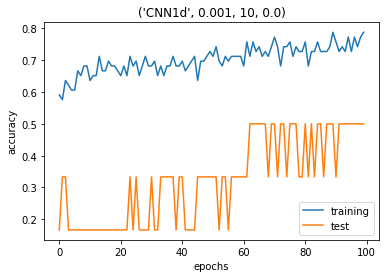

In [102]:
plot(1,train_metrics,None,test_metrics,False)

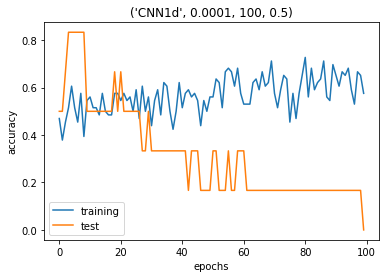

In [96]:
plot(1,train_metrics,None,test_metrics,False)

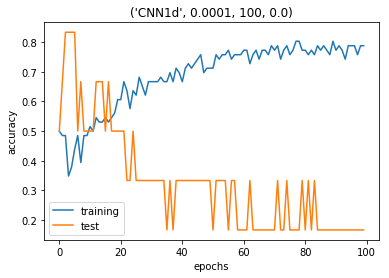

In [91]:
plot(1,train_metrics,None,test_metrics,False)

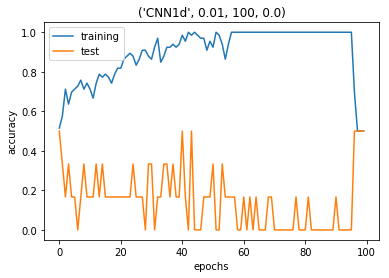

In [83]:
plot(1,train_metrics,None,test_metrics,False)

##  ON FIRST FOLD
- DROPOUT of 0.2 betters the result, model reachers 100% accuracy after 300 epochs
- drop of 0.5 make training unstable
- lr = 1e-3 seems good

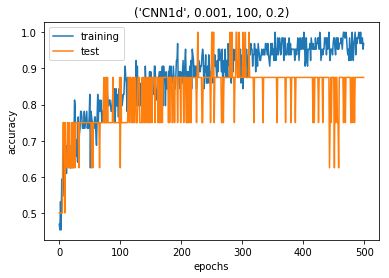

In [66]:
plot(1,train_metrics,None,test_metrics,False)

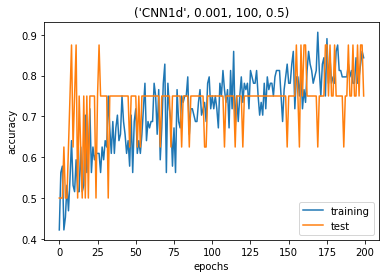

In [38]:
plot(1,train_metrics,None,test_metrics,False)

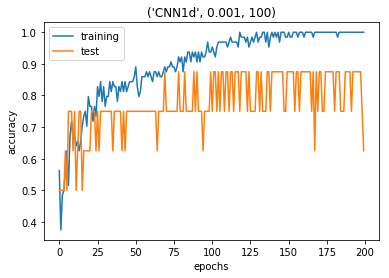

In [27]:
plot(1,train_metrics,None,test_metrics,False)

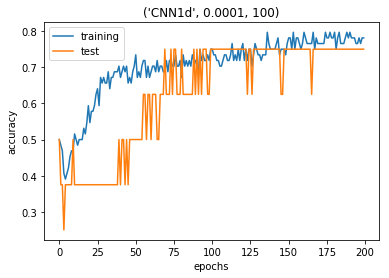

In [24]:
plot(1,train_metrics,None,test_metrics,False)

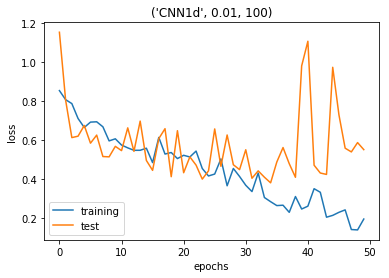

In [14]:
plot(0,train_metrics,None,test_metrics,False)

# Visualization

### Load results

In [103]:
load_results=False

In [108]:
if load_results:
    patience=10
    n_epochs=50
    filename=join("experiments/","stop_loss(0, False, 0.001, 10, 4, False, 0.0, 5.0, None)")#+listdir("experiments")[0][:-4]
    early_stopping=True
    metrics=[]
    for metric_type in ["train","test"]:
        with open (filename+metric_type, 'rb') as fp:
            metrics.append(pickle.load(fp))

    fold_train_metrics, fold_test_metrics=metrics

In [83]:
if early_stopping:
    avg_train=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_train_metrics]),axis=0)
    avg_valid=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_valid_metrics]),axis=0)
    avg_test=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_test_metrics]),axis=0)
else:
    avg_train=np.mean(fold_train_metrics,axis=0)
    #avg_valid=np.mean(fold_valid_metrics,axis=0)
    avg_test=np.mean(fold_test_metrics,axis=0)
    

tcn(0| 0.001| 1| 5| False| 0.5| None| None| 100| 5)


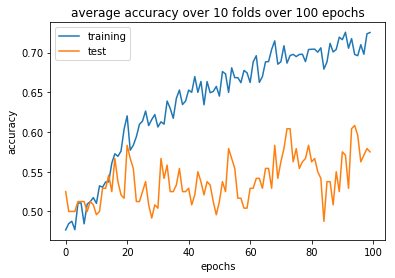

In [86]:
plot(1,avg_train,None,avg_test)

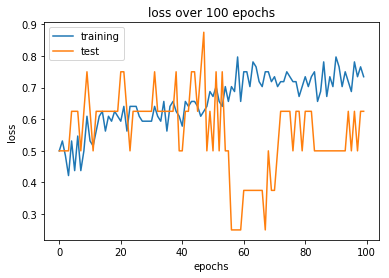

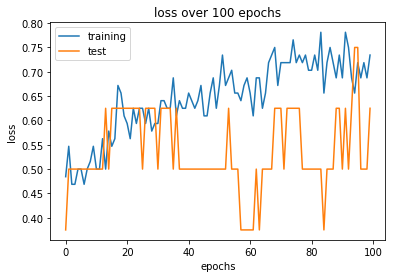

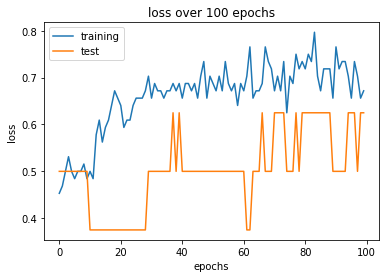

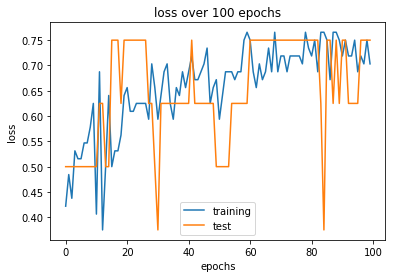

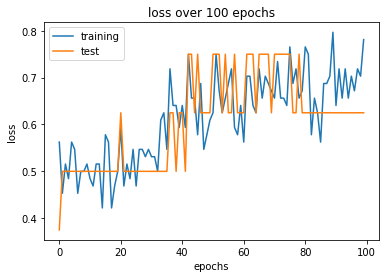

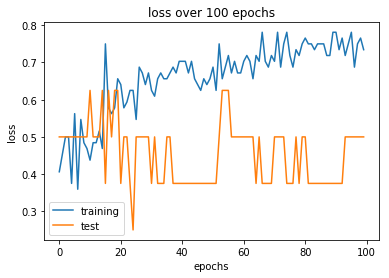

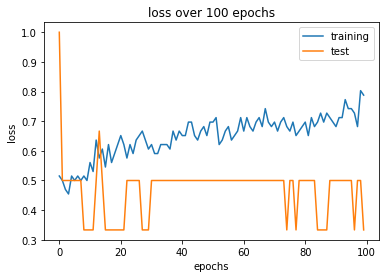

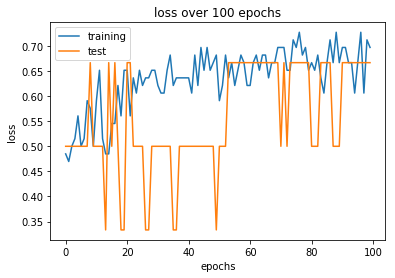

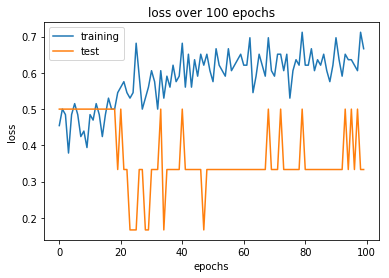

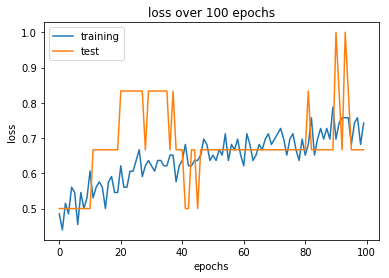

In [98]:
for i in range(10):
    plt.figure()
    plt.title("loss over {} epochs".format(len(fold_train_metrics[i])))
    plt.plot(np.asarray(fold_train_metrics[i])[:,1],label="training")
    plt.plot(np.asarray(fold_test_metrics[i])[:,1],label="test")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()

('CNN1d'| 0.001| 100| 0.2)


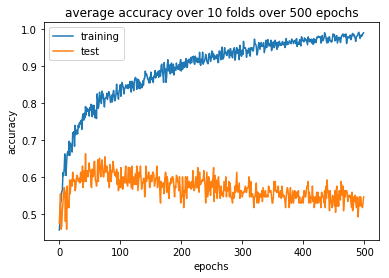

In [76]:
plot(1,avg_train,None,avg_test)

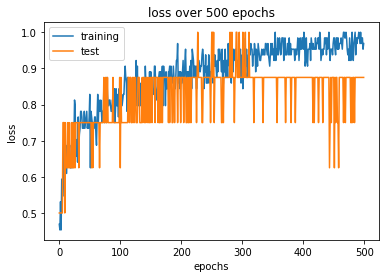

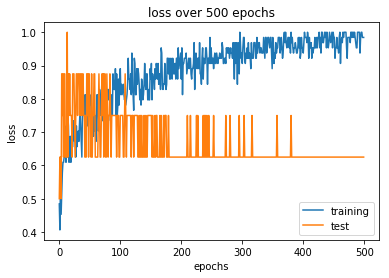

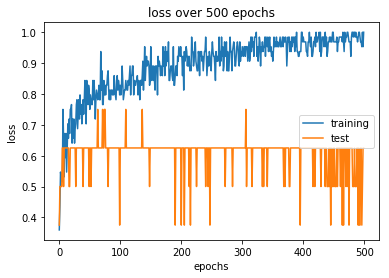

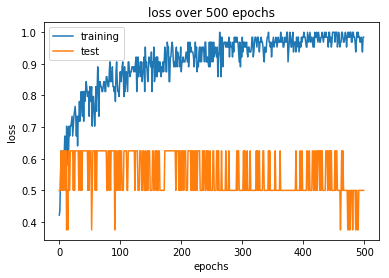

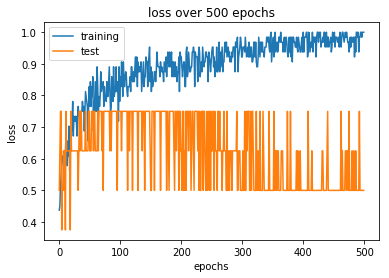

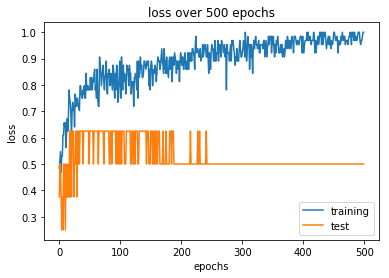

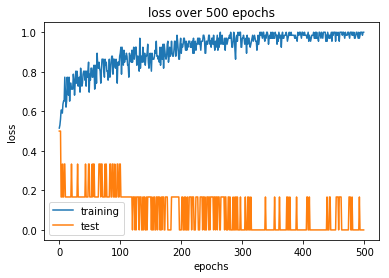

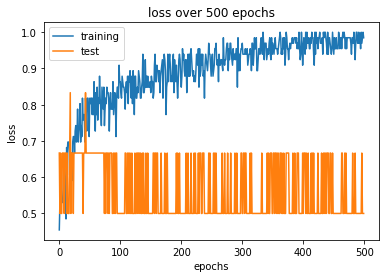

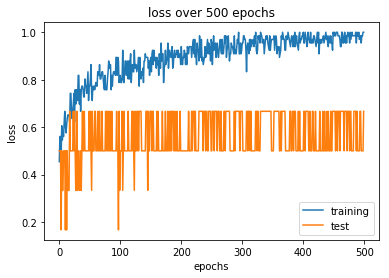

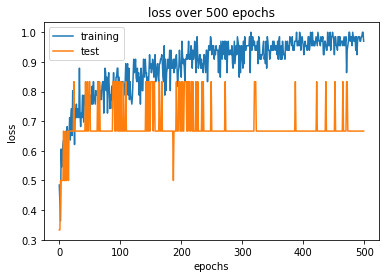

In [77]:
for i in range(10):
    plt.figure()
    plt.title("loss over {} epochs".format(len(fold_train_metrics[i])))
    plt.plot(np.asarray(fold_train_metrics[i])[:,1],label="training")
    plt.plot(np.asarray(fold_test_metrics[i])[:,1],label="test")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()

## Loss

### Spirals
#### baseline

task|model|learning_rate |hidden_size|num_layers|bidirectional| dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
l | GRU | 0.001 | 10   | 4 | False | 0.0 | 5.0 | 5.60 (+ 4.10) | None | False | 

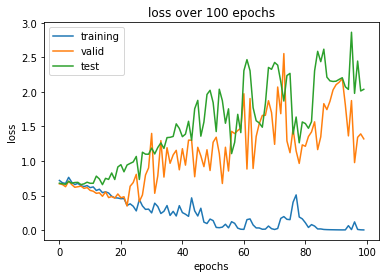

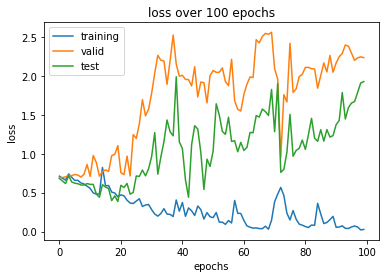

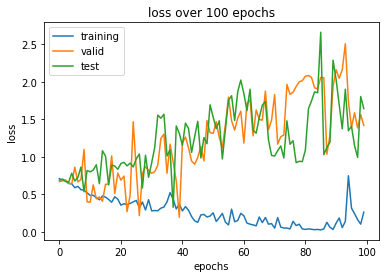

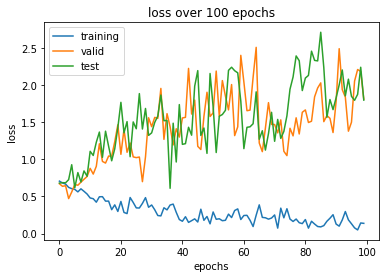

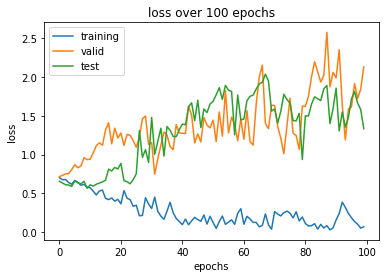

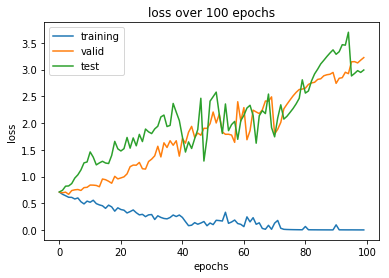

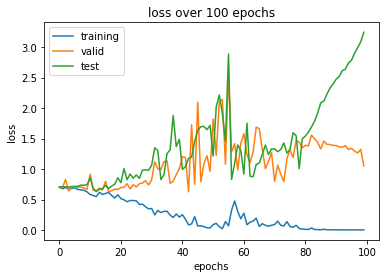

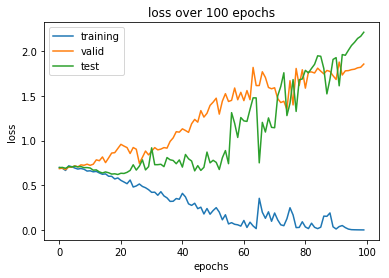

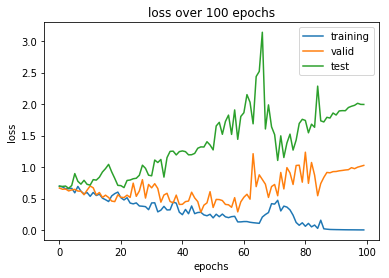

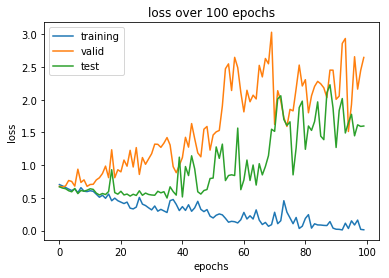

In [78]:
for i in range(10):
    plt.figure()
    plt.title("loss over {} epochs".format(len(fold_train_metrics[i])))
    plt.plot(np.asarray(fold_train_metrics[i])[:,0],label="training")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,0],label="valid")
    plt.plot(np.asarray(fold_test_metrics[i])[:,0],label="test")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()

#### Small baseline

learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | **10** | 1 | True | 0.0 | 5.0 | 5.70 (+ 4.22) | 0.59 (+ 0.06) | 0.67 (+ 0.11) | 0.83 (+ 0.20) | 0.51 (+ 0.25) | 0.65 (+ 0.14) | 0.74 (+ 0.30)

The model seems to overfit less than usual, this is probably because it has way less parameters (~1.5k instead of ~43k)  
Adding an extra layer gives the same behaviour, more or less 

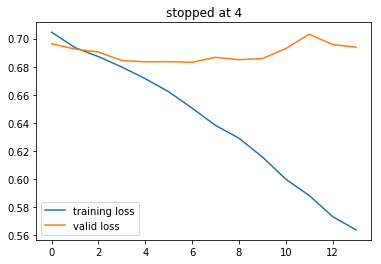

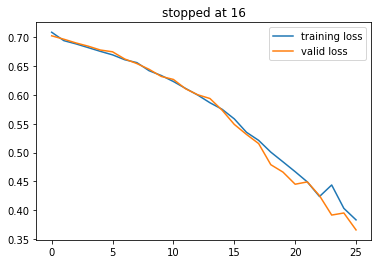

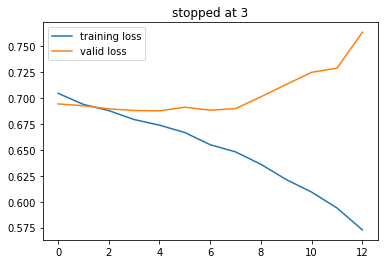

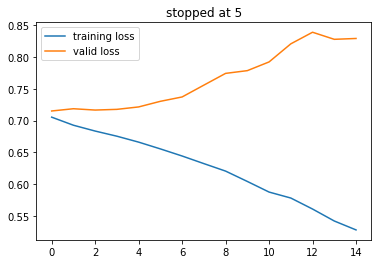

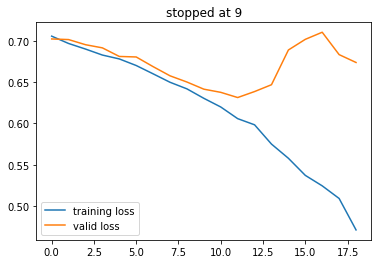

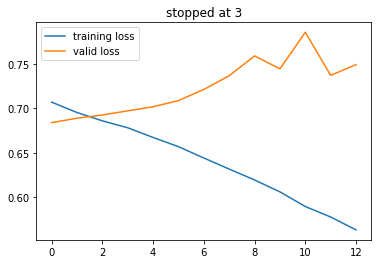

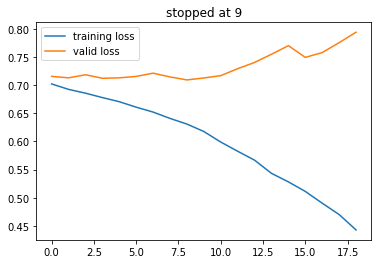

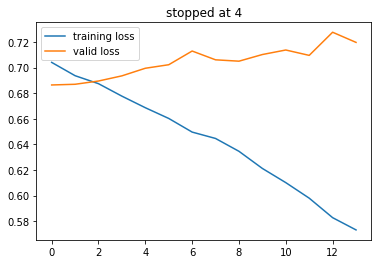

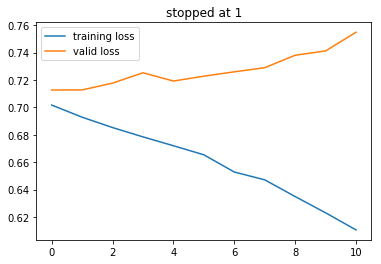

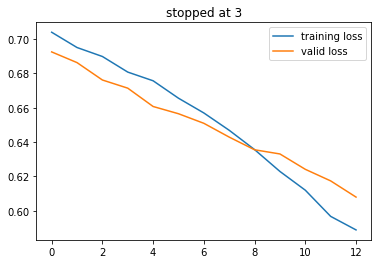

In [179]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,0],label="training loss")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,0],label="valid loss")
    plt.legend()

##### Stronger effect with 4 layers
but the specificity boost comes back  

task|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|carry over | dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--|--
spiral | 1 | 0.001 | 10 | 4 | True |0| 0.5 | 5.0 | 5.50 (+ 3.35) 

![4layers.png](4layers.png)

### l task

##### Small baseline - The model doesn't behave the same way with the l task (with 2 or 3 layers)
task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
l | 1 | 0.001 | 10 | 2 | True | 0.5 | 5.0 | 4.70 (+ 4.31)

l | 1 | 0.001 | 10 | 2 | True | 0.5 | 5.0 | 4.70 (+ 4.31)


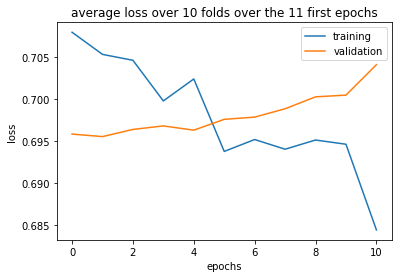

##### Splitting data into strokes & 2 separate models for in_air & on_paper
Should try different parameters, those are not fit.  
Also try to use the same decoder

task|model|learning_rate |hidden_size|num_layers|bidirectional| dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
l | paper_air GRUs, 2 decoders | 0.001 | 10   | 4 | False | 0.0 | 5.0 | 3.80 (+ 2.99) 

l | GRU | 0.001 | 10   | 4 | False | 0.0 | 5.0 | 3.80 (+ 2.99) | None | False | 


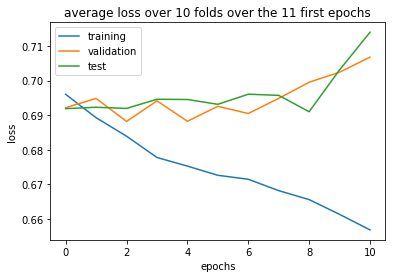

In [116]:
plot(0,avg_train,avg_valid,avg_test)

##### Similar results when using the same decoder
Should try different hyperparams

task|model|learning_rate |hidden_size|num_layers|bidirectional| dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
l |  paper_air LSTMs, 1 decoder | 0.001 | 10   | 4 | False | 0.0 | 5.0 | 6.90 (+ 6.71)

l | LSTM | 0.001 | 10   | 4 | False | 0.0 | 5.0 | 6.90 (+ 6.71) | None | False |


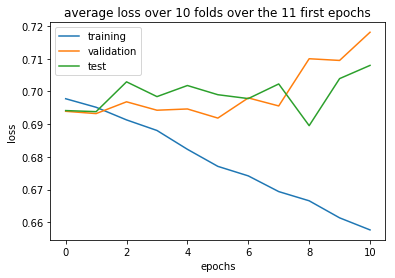

In [19]:
plot(0,avg_train,avg_valid,avg_test)

l | GRU | 0.001 | 10   | 4 | True | 0.5 | 5.0 | 5.60 (+ 4.50) | None | False | T


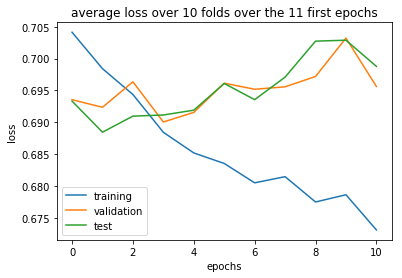

In [32]:
plot(0,avg_train,avg_valid,avg_test)

#####  Computing movement as Zhang et al. helps with the l task

task	| Model | Computing movement | dowsampling factor |learning_rate | hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--|--|--
l | GRU | True | 1 | 0.001 | 10 | 4 | False | 0.0 | 0.0 | 5.0 | 4.60 (+ 2.94) 


l | GRU | True | 1 | 0.001 | 10 | 4 | False | 0.0 | 0.0 | 5.0 | 4.60 (+ 2.94) | 


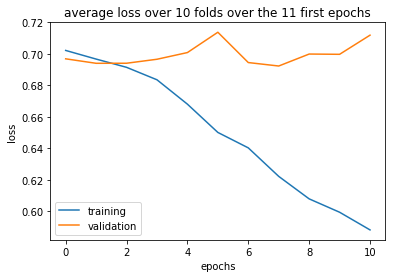

In [136]:
plot_loss()

### Other tasks
task|model|learning_rate |hidden_size|num_layers|bidirectional| dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
2| False| 0.001| 10| 4| False| 0.0| 5.0| None

(2| False| 0.001| 10| 4| False| 0.0| 5.0| None)


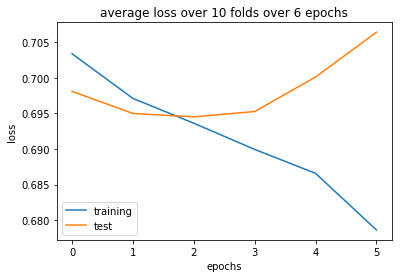

In [27]:
plot(0,avg_train,None,avg_test)

#####  Small baseline - Model doesn't behave the same way with spiral and l & tram task

task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
tram | 1 | 0.001 | 10 | 2 | True | 0.0 | 0.0 | 5.0 | 5.30

![tram](tram.png)

## Accuracy

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
**0.0001** | 100 | 1 | True | 0.0 | 5.0 | 14.80 (+ 12.37) | 0.63 (+ 0.09) | 0.71 (+ 0.09) | 0.55 (+ 0.27) | 0.87 (+ 0.18) | 0.88 (+ 0.15) | 0.70 (+ 0.16) 

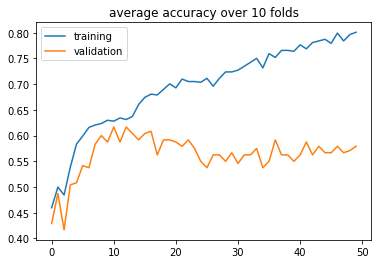

In [104]:
plt.figure()
plt.title("average accuracy over 10 folds")
plt.plot(avg_train[:,1],label="training")
plt.plot(avg_valid[:,1],label="validation")
plt.legend()

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | **10** | 1 | True | 0.0 | 5.0 | 5.70 (+ 4.22) | 0.59 (+ 0.06) | 0.67 (+ 0.11) | 0.83 (+ 0.20) | 0.51 (+ 0.25) | 0.65 (+ 0.14) | 0.74 (+ 0.30)

The model seems to overfit less than usual, this is probably because it has way less parameters (~1.5k instead of ~43k)

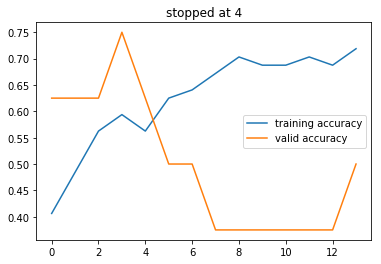

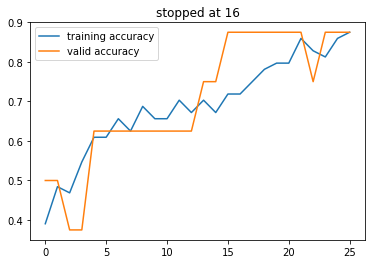

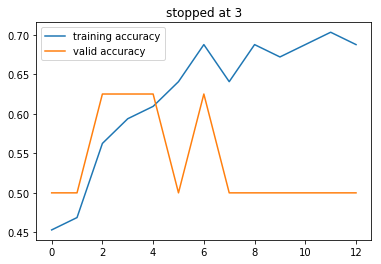

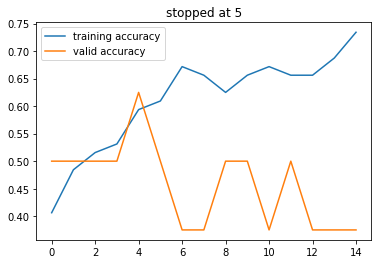

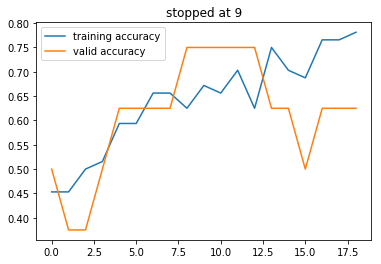

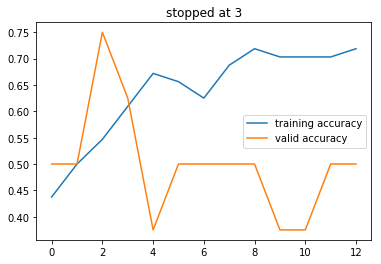

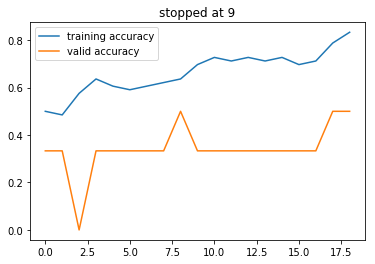

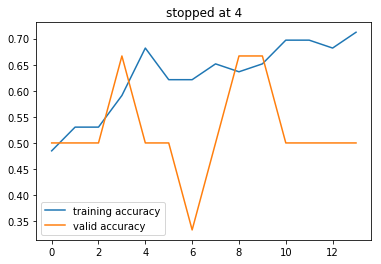

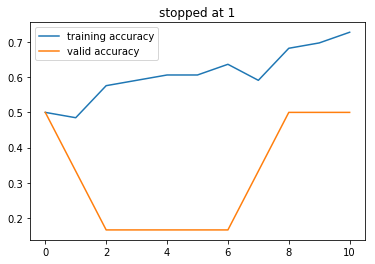

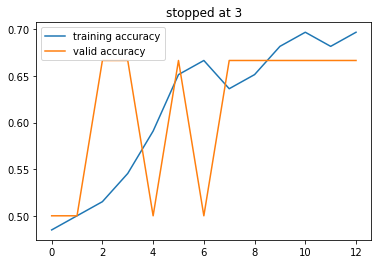

In [180]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,1],label="training accuracy")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,1],label="valid accuracy")
    plt.legend()

##  Interpretation

###  Falses

<Figure size 432x288 with 0 Axes>

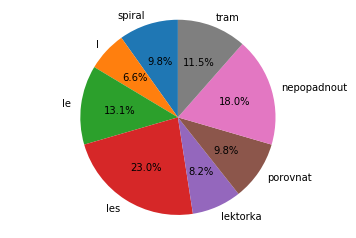

<Figure size 432x288 with 0 Axes>

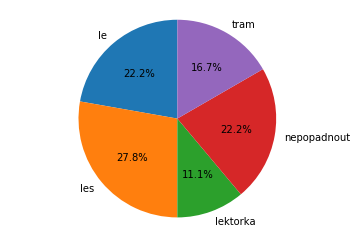

In [492]:
"""figure from the defect implementation !"""
for indexes in [test_index,fold_falses[-2][2]]:
    test_classes=np.argmax([data[i][0][0:8] for i in indexes],axis=1)
    unique,counts=np.unique(test_classes, return_counts=True)
    plt.figure()
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = [index2task[i] for i in unique]
    sizes = counts
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

### Experiments metrics

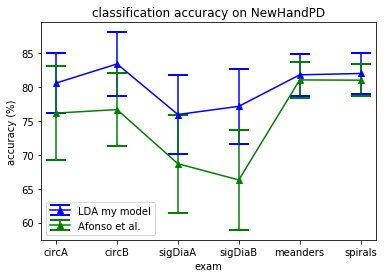

In [102]:
plt.figure()
plt.title("classification accuracy on NewHandPD")
plt.ylabel("accuracy (%)")
plt.xlabel("exam")
for i in [0,1]:
    plt.errorbar(exams[:-1],results[:,:,0][:,i],results[:,:,1][:,i],color=colors[i],label=labels[i], marker='^',capsize=10,capthick=2)
    plt.legend()
    #plt.errorbar(exams[:-1],[0.63,0.7,0.72],[0.16,0.15,0.1],label="layer size = 10", marker='^')

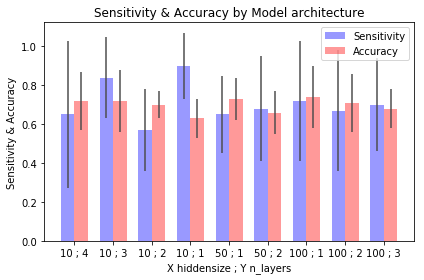

In [34]:
n_groups = len(results)

studied_metric = tuple([float(i[-1][0:5]) for i in results])#(0.74, 0.63, 0.7)
studied_std = tuple([float(i[-1][8:13]) for i in results])#(0.16, 0.1, 0.07)

accuracy_vanilla = tuple([float(i[-2][0:5]) for i in results])
std_vanilla = tuple([float(i[-2][8:13]) for i in results])

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, studied_metric, bar_width,
                alpha=opacity, color='b',
                yerr=studied_std, error_kw=error_config,
                label='Sensitivity')

rects2 = ax.bar(index + bar_width, accuracy_vanilla, bar_width,
                alpha=opacity, color='r',
                yerr=std_vanilla, error_kw=error_config,
                label='Accuracy')

ax.set_xlabel('X hiddensize ; Y n_layers')
ax.set_ylabel('Sensitivity & Accuracy')
ax.set_title('Sensitivity & Accuracy by Model architecture')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(tuple([i[0]+" ; "+i[1] for i in results]))#('100 ; 1', '10 ; 1', '10 ; 2'))
ax.legend()

fig.tight_layout()
plt.show()

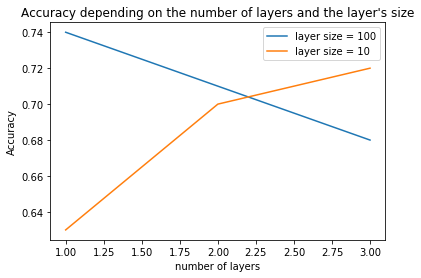

In [124]:
plt.figure()

plt.title("Accuracy depending on the number of layers and the layer's size")
plt.plot(range(1,4),[0.74,0.71,0.68],label="layer size = 100")
plt.plot(range(1,4),[0.63,0.7,0.72],label="layer size = 10")
#plt.errorbar(range(1,4),[0.74,0.71,0.68],[0.16,0.07,0.1],label="layer size = 100", marker='^')
#plt.errorbar(range(1,4),[0.63,0.7,0.72],[0.16,0.15,0.1],label="layer size = 10", marker='^')
plt.xlabel("number of layers")
plt.ylabel("Accuracy")
plt.legend()

## Model weights

In [596]:
fold_train_metrics[0]

[[0.7049412904307246, 0.53125, 0.1875, 0.875, 0.6, 0.5185185185185185]]

In [11]:
print("""the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size) if LSTM and 
(W_ir|W_iz|W_in) of shape (3*hidden_size x input_size) if GRU""")
print(model.encoder.weight_ih_l0.shape)#lstm.weight_ih_l0.shape)
input_weights=model.encoder.weight_ih_l0.cpu().detach().numpy()

the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size) if LSTM and 
(W_ir|W_iz|W_in) of shape (3*hidden_size x input_size) if GRU
torch.Size([30, 9])


[ 0.18169089 -0.04943112  0.06535473  0.01828056  0.01205595 -0.02092264
 -0.07480846  0.0185647  -0.0245374 ]
[ 0.03647731  0.05538079 -0.0206281   0.0765989   0.04889316  0.01612907
 -0.03662204  0.081875    0.05412391]
[ 0.02652793 -0.10414839 -0.0121935  -0.01399441  0.0030055   0.024525
 -0.09067195  0.10848202  0.10834714]


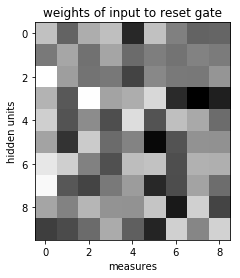

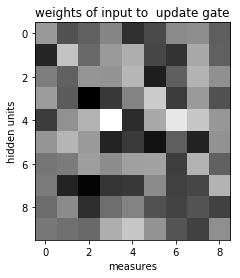

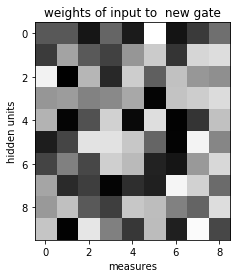

In [16]:
plot_labels="reset gate, update gate, new gate".split(",")
for i,label in enumerate(plot_labels):
    plt.figure()
    plt.title("weights of input to {}".format(label))
    plt.xlabel("measures")
    plt.ylabel("hidden units")
    print(np.mean(input_weights[i*10:i*10+10],axis=0))
    plt.imshow(input_weights[i*10:i*10+10],cmap='gray')v

#### Biases after init at 1


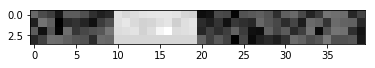

In [358]:
biases=[lstm.bias_hh_l0,
lstm.bias_hh_l0_reverse,
lstm.bias_hh_l1,
lstm.bias_hh_l1_reverse]
for i,b in enumerate(biases):
    biases[i]=b.cpu().detach().numpy()
plt.imshow(biases,cmap='gray')

# Implemented but not used

## Trimming and padding
For spirals we set max_len at 3117 as it's the 3rd quartile of task lengths (i.e. 3/4 subjects have task shorter than 3117 timesteps)

In [10]:
"""
if task_i is None:
    raise NotImplementedError("Multi-task learning is not implemented for trimming and padding")
max_len=3117
for i,task in enumerate(data):
    
    if len(task) > max_len:
        data[i]=task[:max_len]
    else:
        data[i]=np.concatenate((task,np.zeros(shape=(max_len-len(task),7))))"""
print("With this trimming and padding the model won't fit with the same hyperparameters")


With this trimming and padding the model won't fit with the same hyperparameters


## MAB Optim

In [199]:
actions={"increment":0,"idle":1,"decrement":2}
#pessimistic init (reward == loss). 3 because 3 actions
qtable={"is_lstm":np.ones(len(actions)),"learning_rate":np.ones(len(actions)),
        "hidden_size":np.ones(len(actions)),
        "num_layers":np.ones(len(actions)),"bidirectional":np.ones(len(actions)),
        "dropout":np.ones(len(actions)),"clip":np.ones(len(actions))}

hyperparameters_range={"is_lstm":[True,False],
                 "learning_rate":[1e-2,1e-3,1e-4],
                 "hidden_size":[2**i for i in range (1,8)],
                 "num_layers":[i for i in range (1,6)],
                 "bidirectional":[True,False],
                 "dropout":np.arange(0,0.6,0.1),
                 "clip":[1,5,10,50,None]}
#index for hyperparameters_range
hyperparameters={"is_lstm":1,
                 "learning_rate":1,
                 "hidden_size":2,
                 "num_layers":1,
                 "bidirectional":0,
                 "dropout":2,
                 "clip":1}
q_decay_rate = 0.03
q_learning_rate = 0.5

In [170]:
episode = 0
experiments=[]
while True:
    q_exploration_rate=np.exp(-q_decay_rate*episode)#exploration rate update
    save_actions=[]#to update qtable later
    for p in hyperparameters.keys():#choose every hyperparam 
        
        #define what action the agent is able to take
        choose_from=[actions["idle"]]
        if hyperparameters[p]+1 < len(hyperparameters_range[p]):#if we can increment
            choose_from.append(actions["increment"])
        elif hyperparameters[p] > 0:#if we can decrement   
            choose_from.append(actions["decrement"])
            
        if np.random.rand()<q_exploration_rate:#exploration (i.e. random choice)
            action=np.random.choice(choose_from)
        else:
            #"removes" unallowed actions from the qtable
            #replace 1000 with 0 if optimizing accuracy
            allowed_table=[q if i in choose_from else 1000 for i,q in enumerate(qtable[p])]
            action=np.argmin(allowed_table)#argmin because we want to MINimize LOSS        
            
        if action==actions["increment"]:            
            hyperparameters[p]+=1
        elif action==actions["idle"]:
            pass#idle
        elif action==actions["decrement"]:
            hyperparameters[p]-=1
        else:
            raise ValueError("incorrect action index {},expected one of {}".format(action,actions))
        save_actions.append(action)#to update qtable later
    
    #take action (e.g. 10 CV)
    is_lstm=hyperparameters_range["is_lstm"][hyperparameters["is_lstm"]]
    learning_rate = hyperparameters_range["learning_rate"][hyperparameters["learning_rate"]]
    hidden_size=hyperparameters_range["hidden_size"][hyperparameters["hidden_size"]]
    num_layers=hyperparameters_range["num_layers"][hyperparameters["num_layers"]]
    bidirectional=hyperparameters_range["bidirectional"][hyperparameters["bidirectional"]]
    dropout=hyperparameters_range["dropout"][hyperparameters["dropout"]]
    clip=hyperparameters_range["clip"][hyperparameters["clip"]] 
    
    print("\nepisode n°{}, hyperparameters :\n {} ; {} ; {} ; {} ; {} ; {} ; {}".format(
    episode,is_lstm,learning_rate,hidden_size,num_layers,bidirectional,dropout,clip))
    
    verbose=False
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_generator=skf.split(data,targets)
    fold_train_metrics,fold_valid_metrics,fold_falses=[],[],[]
    start = time()
    np.random.seed(1)
    save_to_print=""
    fold=0
    n_epochs=50#max n° of epochs the model will be trained to
    patience = 10#n° of epochs without improvement during which the model will wait before stopping

    for train_index,test_index in cv_generator:     
        train_metrics,valid_metrics,falses=[],[],[]

        torch.manual_seed(1)#random seed for weights init
        model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                     dropout,bidirectional, batch_size, output_size, is_lstm)
        if isinstance(model.encoder,torch.nn.LSTM):
            model.init_forget_bias()
        model=model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        if fold==0:        
            print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())

        best_accuracy=0
        #best_loss=10000.0
        impatience=0
        for i in range(n_epochs):                
            to_print=""
            np.random.shuffle(train_index)
            np.random.shuffle(test_index)
            #training
            model.train()
            [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
            train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
            to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
            to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

            #validation
            model.eval()
            [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
                data, targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)    
            valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
            falses.append(false)
            to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
                loss,accuracy,sensitivity,specificity,ppv,npv)      

            #patience update        
            if accuracy <= best_accuracy:#`<=` no improvement is considered bad !#loss>=best_loss:
                impatience+=1
            else:
                best_accuracy=accuracy #best_loss=loss#
                impatience=0

            if verbose:
                print(to_print)
            save_to_print+=to_print

            #early stopping
            if impatience >= patience:
                save_to_print+="\nEarly stopped."
                break     

        fold_train_metrics.append(train_metrics)
        fold_valid_metrics.append(valid_metrics)
        fold_falses.append(falses)
        fold+=1
    if not verbose:
        print(to_print)#save_to_print)
    experiments.append((fold_train_metrics,fold_valid_metrics,fold_falses,is_lstm,learning_rate,hidden_size,
                       num_layers,bidirectional, dropout,clip))
    #take reward : average loss over the best folds
    if np.max([len(fold) for fold in fold_valid_metrics]) >= n_epochs:
        print("episode n°{}, Warning : the model didn't early stopped therefore we didn't selected the best metric")
    
    reward=np.mean(np.asarray([fold[-patience-1] for fold in fold_valid_metrics])[:,0])
    #update qtable
    for i,p in enumerate(qtable):
        action=save_actions[i]
        qtable[p][action]+=q_learning_rate*(reward-qtable[p][action])
    episode+=1
              

episode n°0, hyperparameters :
 False ; 0.001 ; 128 ; 4 ; True ; 0.4 ; 1
(total n° of parameters, n° of trainable parameters)
 (994689, 994689)


fold n°9, epoch n°18, spent 350m 10s
TRAINING : loss 1.187, accuracy 0.636
VALIDATION : loss 2.055, accuracy 0.500, sensitivity  0.667, specificity 0.333, ppv 0.500, npv 0.500
episode n°1, hyperparameters :
 False ; 0.001 ; 64 ; 5 ; True ; 0.4 ; 5
(total n° of parameters, n° of trainable parameters)
 (326081, 326081)


fold n°9, epoch n°10, spent 244m 37s
TRAINING : loss 0.708, accuracy 0.515
VALIDATION : loss 0.693, accuracy 0.500, sensitivity  1.000, specificity 0.000, ppv 0.500, npv 0.000
episode n°2, hyperparameters :
 False ; 0.001 ; 64 ; 4 ; True ; 0.5 ; 5
(total n° of parameters, n° of trainable parameters)
 (251585, 251585)


fold n°9, epoch n°10, spent 178m 54s
TRAINING : loss 0.703, accuracy 0.606
VALIDATION : loss 0.693, accuracy 0.500, sensitivity  1.000, specificity 0.000, ppv 0.500, npv 0.000
episode n°3, hyperparameters :
 True

KeyError: 'learning_rate'

## Debug

In [14]:
subject=torch.Tensor(data[25]).unsqueeze(0).transpose(1,2)
target=torch.Tensor([targets[25]])
subject=subject.to(device)
target=target.to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [17]:
out=model(subject)

In [18]:
loss_fn=torch.nn.BCELoss()

In [19]:
target

tensor([0.], device='cuda:0')

In [30]:
optimizer.zero_grad()
output=model(subject)


loss = loss_fn(output, target)
loss.backward()
optimizer.step()
print( loss.item(), output.item())

0.09036051481962204 0.08639827370643616


In [28]:
torch.manual_seed(1)#random seed for weights init
encoder=Encoder(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, is_lstm).to(device)
if isinstance(encoder,torch.nn.LSTM):
    encoder.init_forget_bias()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)

#remember to squeeze(0) the output of the decoder in step()
decoder=torch.nn.Sequential(torch.nn.Linear(hidden_size,output_size),
                           torch.nn.Sigmoid()).to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

In [112]:
step_(subject, target, encoder, encoder_optimizer, loss_fn, batch_size,decoder,decoder_optimizer,clip=None,validation = False)

(0.4893574118614197, 0.3869798183441162)

In [33]:
step(subject, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False)

(0.732295036315918, 0.5191957354545593)

In [26]:
torch.manual_seed(1)
model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
if isinstance(model.encoder,torch.nn.LSTM):
    model.init_forget_bias()
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


"""step(subject, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False)
#we pass the hidden state from subject to subject !
#but we detach it because we can't backprop through the whole dataset
model.hidden_state=model.hidden_state.detach()
if is_lstm:
    model.cell_state=model.cell_state.detach()"""

"step(subject, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False)\n#we pass the hidden state from subject to subject !\n#but we detach it because we can't backprop through the whole dataset\nmodel.hidden_state=model.hidden_state.detach()\nif is_lstm:\n    model.cell_state=model.cell_state.detach()"

# stratified 10 cv train valid test

## Discards measures
keep only `keep_measures`

In [32]:
keep_measures=np.array([measure2index["y-coordinate"],measure2index["x-coordinate"],
              measure2index["tilt"],measure2index["elevation"],measure2index["pressure"]])
for i in range(len(data)):
    data[i]=data[i][:,keep_measures]

## Reload dependencies

In [24]:
%load_ext autoreload
%autoreload 2

# EXCEL TO ARRAY

In [20]:
lines="""exam	LDA (my model)	Afonso et al.	Pereira et al. 2018
circA	80.61 ± (4.40)	76.17±6.92	68.04 ± 2.96
circB	83.43 ± (4.68)	76.69±5.38	73.41 ± 3.66
sigDiaA	75.96 ± (5.90)	68.69±7.26	73.59 ± 3.57
sigDiaB	77.17 ± (5.52)	66.30±7.38	76.32 ± 5.18
meanders	81.82 ± (3.13)	81.07±2.60	80.75 ± 2.08
spirals	82.02 ± (3.02)	81.03±2.40	78.26 ± 1.97
all	83.84 ± (3.26)	NA	95.74 ± 1.60""".replace("(","").replace(")","").split("\n")

lines=[line.split("\t") for line in lines]

lines=np.asarray(lines)

exams=lines[1:,0]

labels=lines[0,1:]

results=lines[1:-1,1:]

results

results=np.array(results).astype(float)

results

results[:,:,0][:,0]

results[:,:,1]

colors=["b","g","r"]

plt.figure()
plt.title("classification accuracy on NewHandPD")
plt.ylabel("accuracy (%)")
plt.xlabel("exam")
for i,_ in enumerate(labels):
    plt.errorbar(exams[:-1],results[:,:,0][:,i],results[:,:,1][:,i],color=colors[i],label=labels[i], marker='^',capsize=10,capthick=2)
    plt.legend()
    #plt.errorbar(exams[:-1],[0.63,0.7,0.72],[0.16,0.15,0.1],label="layer size = 10", marker='^')

#  early stopping

In [35]:
#split in train valid and test set
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data,targets)
cv_matrix=[[tmp_index,test_index] for tmp_index,test_index in cv_generator]
for i,fold in enumerate(cv_matrix):
    #validate on the next fold test set (or on the first fold test set if last fold)
    #10 because 10 cross validation
    valid_index=cv_matrix[i+1][1] if i+1 < 10 else cv_matrix[0][2]
    #removes valid set from tmp_index
    train_index=[index for index in fold[0] if index not in valid_index]
    cv_matrix[i]=[train_index,valid_index,fold[1]]

run_CV=True#if False, breaks after one fold, else runs CV
#n° of epochs without improvement during which the model will wait before stopping (if early_stopping)
#useless if not early_stopping
patience = 10
verbose=False
fold_train_metrics,fold_valid_metrics,fold_test_metrics,fold_falses=[],[],[],[]
start = time()
np.random.seed(1)
save_to_print=""

for fold,(train_index,valid_index,test_index) in enumerate(cv_matrix): 
    
    n_epochs=50#max n° of epochs the model will be trained to
    early_stopping=True
    train_on_validation=False
    train_metrics,valid_metrics,test_metrics,falses=[],[],[],[]

    torch.manual_seed(1)#random seed for weights init
    model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                     dropout,bidirectional, batch_size,output_size, is_lstm).to(device)
    if isinstance(model,torch.nn.LSTM):
        model.init_forget_bias()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if fold==0:        
        print("(total n° of parameters, n° of trainable parameters)")
        print(model.count_params())

    #best_accuracy=0
    best_loss=10000.0
    impatience=0
    i=0
    while i <n_epochs:               
        to_print=""
        np.random.shuffle(train_index)#shuffle training to facilitate SGD        
        #training
        model.train()
        [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, train_index,device=device,
            clip=clip,validation=False,window_size=window_size,task_i=task_i,augmentation=augmentation,paper_air_split=paper_air_split)
        train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
        to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

        #validate
        if train_on_validation:
            model.train()
        else:
            model.eval()
        [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, valid_index,device=device,
            validation=train_on_validation,window_size=window_size,task_i=task_i,augmentation=augmentation,paper_air_split=paper_air_split)    
        valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)      

        if early_stopping:
            #patience update
            if loss>=best_loss :#accuracy <= best_accuracy:#`<=` no improvement is considered bad !
                impatience+=1
            else:
                best_loss=loss#best_accuracy=accuracy #
                impatience=0
                #save the best model
                directory = join("weights", model_name)
                if not exists(directory):
                    makedirs(directory)
                torch.save({
                    'epoch': i,
                    'model': model.state_dict(),
                    'opt': optimizer.state_dict(),
                    'loss': loss
                }, join(directory, '{}_{}_checkpoint.tar'.format(fold,i)))

        #test
        [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, test_index,device=device,
            validation=True,window_size=window_size,task_i=task_i,augmentation=False,paper_air_split=paper_air_split)    
        test_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        falses.append(false)
        to_print+="\nTEST : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)  
        
        if verbose:
            print(to_print)
        save_to_print+=to_print
        #early stopping
        if impatience >= patience and early_stopping:
            save_to_print+="\nEarly stopped."
            early_stopping=False
            n_epochs=i+5#train for 5 more epochs on both training and validation set#break    
            train_on_validation=True
            #reload best model
            best_epoch=i-patience
            load_model = join("weights", #parent directory
                                model_name,#model type
                                '{}_{}_checkpoint.tar'.format(fold,best_epoch)#epoch to load at
                               )
            checkpoint = torch.load(load_model)
            model_sd = checkpoint['model']
            optimizer_sd = checkpoint['opt']
            model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                             dropout,bidirectional, batch_size,output_size, is_lstm).to(device)
            model.load_state_dict(model_sd)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            optimizer.load_state_dict(optimizer_sd)
        i+=1#next epoch
    fold_train_metrics.append(train_metrics)
    fold_valid_metrics.append(valid_metrics)
    fold_test_metrics.append(test_metrics)
    fold_falses.append(falses)
    if not run_CV:
        break
early_stopping=True
n_epochs=50
if not verbose:
    print(to_print)#save_to_print)

if run_CV:   
    # Save metrics
    filename=join("experiments",model_name)
    for metrics,metric_type in list(zip([fold_train_metrics,
    fold_test_metrics],["train","test"])):
        with open(filename+metric_type, 'wb') as fp:
            pickle.dump(metrics, fp)
    
    shortest_fold=print_results()  

(total n° of parameters, n° of trainable parameters)
(2561, 2561)


KeyboardInterrupt: 